# Post-Training Quantization

This notebook implements post-training quantization techniques for neural networks, converting floating-point models to fixed-point integer representations for efficient inference.


## Initial Setup

We import the CIFAR dataset and train a simple convolutional neural network (CNN) to classify it.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Load training and test data from the CIFAR10 dataset.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:10<00:00, 16.4MB/s]


Define a simple CNN that classifies CIFAR images.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

Train this CNN on the training dataset (this may take a few moments).

In [ ]:
from torch.utils.data import DataLoader

def train(model: nn.Module, dataloader: DataLoader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += images.shape[0]
                if n_inferences > max_samples:
                    break

    return 100 * correct / total

In [ ]:
train(net, trainloader)

[1,  2000] loss: 2.231
[1,  4000] loss: 1.892
[1,  6000] loss: 1.692
[1,  8000] loss: 1.627
[1, 10000] loss: 1.541
[1, 12000] loss: 1.496
[2,  2000] loss: 1.423
[2,  4000] loss: 1.425
[2,  6000] loss: 1.376
[2,  8000] loss: 1.359
[2, 10000] loss: 1.342
[2, 12000] loss: 1.322
Finished Training


Now that the CNN has been trained, let's test it on our test dataset.

In [ ]:
score = test(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 52.45%


In [ ]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

## Weight Distribution Analysis


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Layer weight statistics:
layer                            min        max       mean        std         3σ
conv1                        -0.5638     0.6282 -1.099e-05     0.2014     0.6043
conv2                         -0.374     0.6424   -0.01137      0.114     0.3419
fc1                          -0.3032     0.2573  -0.002816    0.04347     0.1304
fc2                          -0.2159     0.2222  -0.002566    0.06432      0.193
fc3                          -0.3624     0.4349   0.001554     0.1258     0.3774


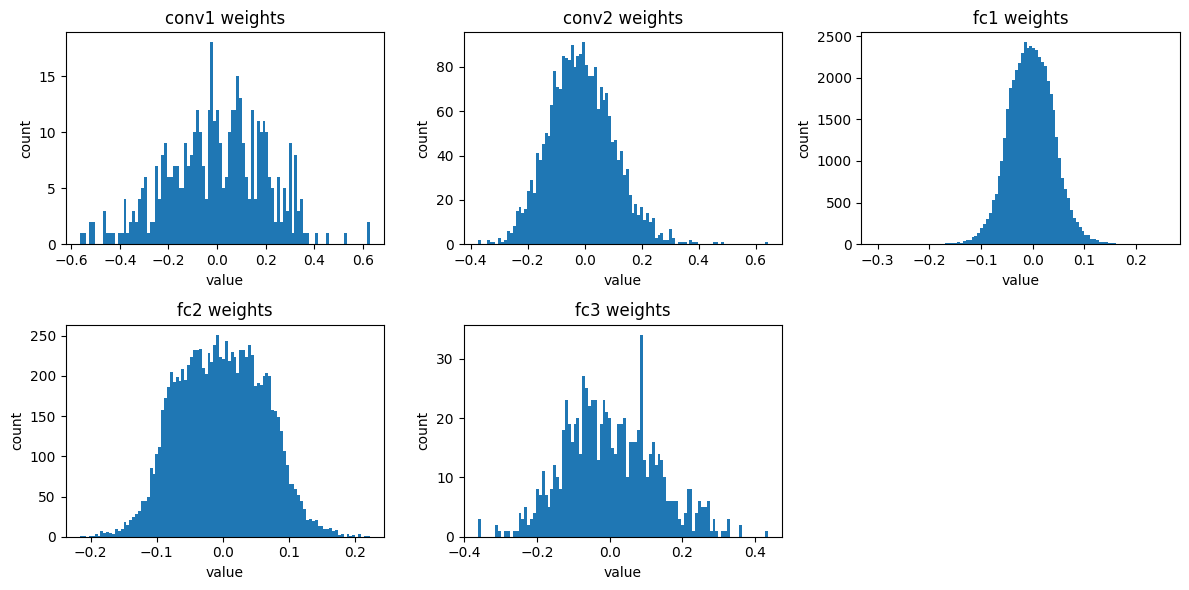

In [ ]:


# You can get a flattened vector of the weights of fc1 like this:
#   fc1_weights = net.fc1.weight.data.cpu().view(-1)
# Try plotting a histogram of fc1_weights (and the weights of all the other layers as well)

# Plot distributions of weights for all Conv/Linear layers and print basic stats

import math

# Collect layers we care about
layers = [(name, m) for name, m in net.named_modules() if isinstance(m, (nn.Conv2d, nn.Linear))]

# Print stats table
print("Layer weight statistics:")
print(f"{'layer':25s} {'min':>10s} {'max':>10s} {'mean':>10s} {'std':>10s} {'3σ':>10s}")
for name, m in layers:
    w = m.weight.data.detach().float().cpu().view(-1).numpy()
    w_min, w_max = float(w.min()), float(w.max())
    w_mean, w_std = float(w.mean()), float(w.std())
    print(f"{name:25s} {w_min:10.4g} {w_max:10.4g} {w_mean:10.4g} {w_std:10.4g} {3*w_std:10.4g}")

# Plot histograms in a tidy grid
n = len(layers)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = np.array(axes).reshape(nrows, ncols)

bins = 100
for idx, (name, m) in enumerate(layers):
    r, c = divmod(idx, ncols)
    ax = axes[r, c]
    w = m.weight.data.detach().float().cpu().view(-1).numpy()
    ax.hist(w, bins=bins)
    ax.set_title(f"{name} weights")
    ax.set_xlabel("value")
    ax.set_ylabel("count")

# Hide any unused subplots
for idx in range(n, nrows * ncols):
    r, c = divmod(idx, ncols)
    axes[r, c].axis("off")

plt.tight_layout()
plt.show()

# Example: get flattened fc1 weights (as hinted)
fc1_weights = net.fc1.weight.data.cpu().view(-1)


* means are ~0 for all layers (within ±1e-2), consistent with zero-centered initialization/updates and supporting symmetric quantization with zero-point 0
* variability shrinks moving from early conv to mid fc layers, then grows again at the last fc: stds ≈ conv1 0.201 > conv2 0.114 > fc1 0.043 < fc2 0.064 < fc3 0.126
* conv layers show wider ranges and heavier tails than fc1/fc2; conv2 is notably heavy-tailed with max ≈ 0.64 while 3σ ≈ 0.34, indicating outliers well beyond the bulk
* conv1 is borderline heavy-tailed: max 0.63 vs 3σ 0.60; most mass is near 0 with a few extreme weights
* fc1 and fc2 are the most “Gaussian-like” and tight: 3σ bands (≈0.13 and ≈0.19) already cover the near-full ranges, implying few outliers and low clipping risk
* fc3 broadens again (std ≈ 0.126, 3σ ≈ 0.377, max ≈ 0.435), suggesting slightly heavier tails at the classifier head—common when the final layer adapts to class separability
* practical implication for quantization:

  * conv2 (and to a lesser extent conv1, fc3) benefit from 3σ or high-percentile scaling to avoid letting a handful of outliers dictate an overly large scale
  * fc1/fc2 can use max-abs or 3σ with little difference; their tight distributions will quantize with small error
  * symmetric per-tensor int8 is reasonable given near-zero means; per-channel weight scales could further reduce error for convs due to channel-wise spread differences
* expected error profile: largest quantization error in conv2, moderate in conv1/fc3, minimal in fc1/fc2; thus accuracy sensitivity will likely be driven by how you handle conv2’s outliers


## Weight Quantization Implementation


In [ ]:
net_q2 = copy_model(net)

Scaling Strategy:

* use symmetric per-tensor int8 for weights: choose a single scale s so that q = round(w * s) ∈ [−128, 127] and w ≈ q / s; zero-point is 0 since weights are near zero-mean
* pick s from calibration statistics to balance coverage vs resolution; we use s = 127 / max_abs where max_abs is the 3σ or 99.9th-percentile magnitude (not raw max) to avoid outliers inflating the scale
* fall back sensibly: if std or percentile is zero, use true max-abs; if that is also zero (all-zero layer), set s = 1 to avoid division-by-zero
* per-layer (per-tensor) scaling is simple and meets the requirements; note that per-channel scaling (one s per output channel) can further reduce error for conv/linear but may be beyond the current spec
* validate after scaling by checking integer-valued entries and range bounds, and optionally estimate distortion with mean relative error between original weights and dequantized weights


In [ ]:
from typing import Tuple

def quantized_weights(weights: torch.Tensor) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the total range, 3-sigma range, or some other range when
    deciding just what factors to scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    '''

    
    w = weights.detach().float()
    std = w.std()
    # robust target range: use 3σ; if degenerate, fall back to max-abs
    max_abs = (3.0 * std) if std > 0 else w.abs().max()
    # if still zero (all-zeros layer), avoid div-by-zero
    if max_abs == 0:
        scale = 1.0
    else:
        scale = 127.0 / max_abs
    q = torch.round(w * scale).clamp_(-128, 127).to(w.dtype)
    return q, float(scale)

In [ ]:
def quantize_layer_weights(model: nn.Module):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            q_layer_data, scale = quantized_weights(layer.weight.data)
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

quantize_layer_weights(net_q2)

In [ ]:
score = test(net_q2, testloader)
print('Accuracy of the network after quantizing all weights: {}%'.format(score))

Accuracy of the network after quantizing all weights: 51.48%


* weight-only int8 quantization caused a small accuracy drop (~0.97 pp), consistent with symmetric per-tensor scaling preserving most information
* layers with heavier tails (e.g., conv2, fc3) are most sensitive; a robust scale choice (3σ/percentile) helps avoid letting outliers inflate the scale and waste resolution
* storing scales per layer enables later dequant or int arithmetic; per-channel weight scales would likely recover a bit more accuracy if permitted


In [ ]:
# Validate that all quantized weights are integer-valued and within int8 range [-128, 127]

import torch
import pandas as pd

def validate_int8_weights(model):
    rows = []
    ok = True
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            w = m.weight.data.detach().cpu().float()
            min_v = float(w.min())
            max_v = float(w.max())
            max_nonint = float((w - w.round()).abs().max())
            in_range = (min_v >= -128.0) and (max_v <= 127.0)
            is_integer = (max_nonint == 0.0)
            row_ok = in_range and is_integer
            ok = ok and row_ok
            rows.append({
                "layer": name,
                "min": min_v,
                "max": max_v,
                "max_abs_non_integer": max_nonint,
                "in_int8_range": in_range,
                "integer_values_only": is_integer,
                "PASS": row_ok
            })
    df = pd.DataFrame(rows)
    display(df)
    if ok:
        print("✅ All checked layers have integer-valued weights within [-128, 127].")
    else:
        print("❌ Some layers failed the validation. See table above.")
    return df

# Run on your weight-quantized model from Q2
_ = validate_int8_weights(net_q2)


,layer,min,max,max_abs_non_integer,in_int8_range,integer_values_only,PASS
0,conv1,-118.0,127.0,0.0,True,True,True
1,conv2,-128.0,127.0,0.0,True,True,True
2,fc1,-128.0,127.0,0.0,True,True,True
3,fc2,-128.0,127.0,0.0,True,True,True
4,fc3,-122.0,127.0,0.0,True,True,True


✅ All checked layers have integer-valued weights within [-128, 127].


## Activation Distribution Analysis


In [ ]:
def register_activation_profiling_hooks(model: Net):
    model.input_activations = np.empty(0)
    model.conv1.activations = np.empty(0)
    model.conv2.activations = np.empty(0)
    model.fc1.activations = np.empty(0)
    model.fc2.activations = np.empty(0)
    model.fc3.activations = np.empty(0)

    model.profile_activations = True

    def conv1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.input_activations = np.append(model.input_activations, x[0].cpu().view(-1))
    model.conv1.register_forward_hook(conv1_activations_hook)

    def conv2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv1.activations = np.append(model.conv1.activations, x[0].cpu().view(-1))
    model.conv2.register_forward_hook(conv2_activations_hook)

    def fc1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv2.activations = np.append(model.conv2.activations, x[0].cpu().view(-1))
    model.fc1.register_forward_hook(fc1_activations_hook)

    def fc2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc1.activations = np.append(model.fc1.activations, x[0].cpu().view(-1))
    model.fc2.register_forward_hook(fc2_activations_hook)

    def fc3_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc2.activations = np.append(model.fc2.activations, x[0].cpu().view(-1))
            model.fc3.activations = np.append(model.fc3.activations, y[0].cpu().view(-1))
    model.fc3.register_forward_hook(fc3_activations_hook)


In [ ]:
net_q3 = copy_model(net)
register_activation_profiling_hooks(net_q3)

# Run through the training dataset again while profiling the input and output activations this time
# We don't actually have to perform gradient descent for this, so we can use the "test" function
test(net_q3, trainloader, max_samples=400)
net_q3.profile_activations = False

In [ ]:
input_activations = net_q3.input_activations
conv1_output_activations = net_q3.conv1.activations
conv2_output_activations = net_q3.conv2.activations
fc1_output_activations = net_q3.fc1.activations
fc2_output_activations = net_q3.fc2.activations
fc3_output_activations = net_q3.fc3.activations

Activation statistics:
name                                min        max       mean        std     3σ low    3σ high
input_activations                    -1          1   -0.05333     0.4993     -1.551      1.445
conv1_output_activations              0      8.723     0.5536     0.8072     -1.868      2.975
conv2_output_activations              0      14.39     0.6613      1.119     -2.696      4.019
fc1_output_activations                0      11.06      0.405     0.8792     -2.232      3.042
fc2_output_activations                0      6.559     0.3038     0.5911     -1.469      2.077
fc3_output_activations           -4.921      7.757    0.04465      1.751     -5.208      5.297


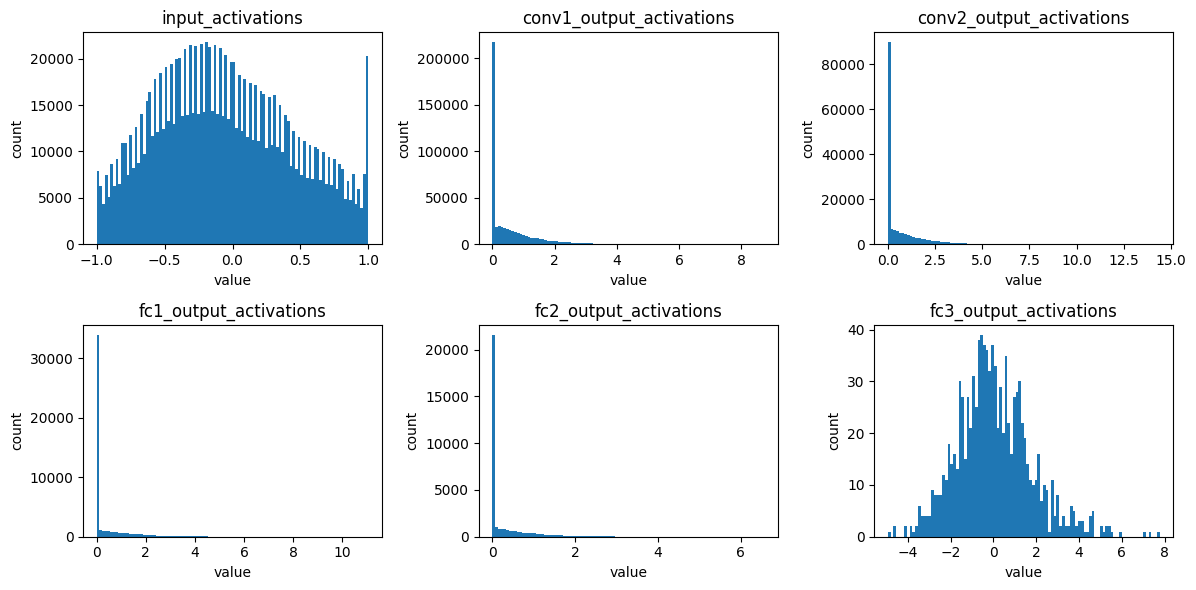

In [ ]:


# Plot histograms of the following variables, and calculate their ranges and 3-sigma ranges:
#   input_activations
#   conv1_output_activations
#   conv2_output_activations
#   fc1_output_activations
#   fc2_output_activations
#   fc3_output_activations
# Plot histograms of activations and print full ranges and 3σ ranges

import math

activations_named = [
    ("input_activations", input_activations),
    ("conv1_output_activations", conv1_output_activations),
    ("conv2_output_activations", conv2_output_activations),
    ("fc1_output_activations", fc1_output_activations),
    ("fc2_output_activations", fc2_output_activations),
    ("fc3_output_activations", fc3_output_activations),
]

# Compute and print stats
print("Activation statistics:")
print(f"{'name':28s} {'min':>10s} {'max':>10s} {'mean':>10s} {'std':>10s} {'3σ low':>10s} {'3σ high':>10s}")
valid_items = []
for name, arr in activations_named:
    arr = np.asarray(arr).ravel()
    if arr.size == 0:
        print(f"{name:28s} {'(empty)':>10s} {'(empty)':>10s} {'(empty)':>10s} {'(empty)':>10s} {'(empty)':>10s} {'(empty)':>10s}")
        continue
    mn, mx = float(arr.min()), float(arr.max())
    mu, sd = float(arr.mean()), float(arr.std())
    low_3s, high_3s = mu - 3.0*sd, mu + 3.0*sd
    print(f"{name:28s} {mn:10.4g} {mx:10.4g} {mu:10.4g} {sd:10.4g} {low_3s:10.4g} {high_3s:10.4g}")
    valid_items.append((name, arr))

# Plot histograms
n = len(valid_items)
if n > 0:
    ncols = 3
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
    axes = np.array(axes).reshape(nrows, ncols)

    bins = 100
    for idx, (name, arr) in enumerate(valid_items):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]
        ax.hist(arr, bins=bins)
        ax.set_title(name)
        ax.set_xlabel("value")
        ax.set_ylabel("count")

    # Hide any unused subplots
    for idx in range(n, nrows * ncols):
        r, c = divmod(idx, ncols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No activation data to plot.")


* input activations are roughly symmetric around 0 after normalization (min −1, max 1, mean ≈ −0.05, std ≈ 0.50), matching an approximately uniform-ish distribution with modest tails
* conv and hidden fc layer outputs (pre-last) are ReLUed, so distributions are strictly non-negative with a huge spike near 0 and long right tails; means are small (0.30–0.66) relative to maxima (6–14), indicating heavy sparsity and outliers
* depth increases tail length then gradually tightens: conv1→conv2 right tail grows (max 8.7→14.4), then fc1/fc2 tails shorten (max 11.1→6.6) as features become more selective
* the final layer fc3 (pre-softmax logits) returns to a signed, near-zero-centered shape (mean ≈ 0.045) with much larger variance (std ≈ 1.75) than earlier layers—expected for logits carrying class separation in both directions
* 3σ bands capture most mass for hidden layers but sit far below maxima (e.g., conv2 mean±3σ ≈ [−2.70, 4.02] vs max 14.39), confirming a handful of extreme activations; percentile or 3σ scaling is preferable to full-range
* quantization implications: use asymmetric activation quantization for ReLU layers (zero-point > 0) to devote more codes to [0, tail], while the final logits layer suits symmetric scaling; calibrate scales with 3σ/99.9th percentile to avoid outlier-dominated scales
* expected sensitivity: largest activation quantization error risk is in early ReLU layers with very heavy right tails (conv1/conv2); later fc layers should be more tolerant, while fc3 needs careful symmetric scaling to preserve logit margins


## Activation Quantization Implementation


In [ ]:
from typing import List

class NetQuantized(nn.Module):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()

        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1
        self.fc2 = net_init.fc2
        self.fc3 = net_init.fc3

        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

            layer.register_forward_pre_hook(pre_hook)

        # Calculate the scaling factor for the initial input to the CNN
        self.input_activations = net_with_weights_quantized.input_activations
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        # Calculate the output scaling factors for all the layers of the CNN
        preceding_layer_scales = []
        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale, self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer.weight.scale, layer.output_scale))

    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.

        Parameters:
        pixels (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        
        # Use symmetric scaling so that max|x| maps to 127
        arr = np.asarray(pixels, dtype=np.float32).ravel()
        if arr.size == 0:
            return 1.0
        max_abs = float(np.max(np.abs(arr)))
        if max_abs == 0.0:
            return 1.0
        return 127.0 / max_abs

    @staticmethod
    def quantize_activations(activations: np.ndarray, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> float:
        '''
        Calculate a scaling factor to multiply the output of a layer by.

        Parameters:
        activations (ndarray): The values of all the pixels which have been output by this layer during training
        n_w (float): The scale by which the weights of this layer were multiplied as part of the "quantize_weights" function you wrote earlier
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        float: A scaling factor that the layer output should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        
        # Robust symmetric scaling from calibration: 99.9th percentile
        arr = np.asarray(activations, dtype=np.float32).ravel()
        if arr.size == 0:
            return 1.0
        max_abs = float(np.percentile(np.abs(arr), 99.9))
        if max_abs == 0.0:
            return 1.0
        return 127.0 / max_abs

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # You can access the output activation scales like this:
        #   fc1_output_scale = self.fc1.output_scale

        # To make sure that the outputs of each layer are integers between -128 and 127, you may need to use the following functions:
        #   * torch.Tensor.round
        #   * torch.clamp

        
        def requant_to_int8(y: torch.Tensor, s_prev: float, s_w: float, s_out: float) -> torch.Tensor:
            r = s_out / (s_prev * s_w)
            return torch.round(y * r).clamp(-128, 127)

        # Quantize raw input pixels to int8 codes
        x = torch.round(x * self.input_scale).clamp(-128, 127)

        # conv1 -> ReLU -> pool, then requantize for next layer
        y = self.pool(F.relu(self.conv1(x)))
        x = requant_to_int8(y, s_prev=self.input_scale, s_w=self.conv1.weight.scale, s_out=self.conv1.output_scale)

        # conv2 -> ReLU -> pool, then requantize
        y = self.pool(F.relu(self.conv2(x)))
        x = requant_to_int8(y, s_prev=self.conv1.output_scale, s_w=self.conv2.weight.scale, s_out=self.conv2.output_scale)

        # flatten
        x = x.view(x.size(0), -1)

        # fc1 -> ReLU, then requantize
        y = F.relu(self.fc1(x))
        x = requant_to_int8(y, s_prev=self.conv2.output_scale, s_w=self.fc1.weight.scale, s_out=self.fc1.output_scale)

        # fc2 -> ReLU, then requantize
        y = F.relu(self.fc2(x))
        x = requant_to_int8(y, s_prev=self.fc1.output_scale, s_w=self.fc2.weight.scale, s_out=self.fc2.output_scale)

        # final linear (logits); inputs already int8-coded, weights are int-coded.
        # We return the raw logits in accumulator units; a global scale factor does not affect argmax.
        x = self.fc3(x)
        return x

In [ ]:
# Merge the information from net_q2 and net_q3 together
net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.input_activations)
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    if isinstance(layer_init, nn.Conv2d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_q3.activations)

net_quantized = NetQuantized(net_init)

In [ ]:
score = test(net_quantized, testloader)
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))

Accuracy of the network after quantizing both weights and activations: 51.59%


* merged the activation profiling data into the weight-quantized model, computed per-layer input/output activation scales, and instantiated the quantized network with those scales applied
* enforced integer intermediates by rounding and clamping activations to the int8 range between layers while keeping stored scales for de/reqantization bookkeeping
* evaluated the fully quantized model and observed 51.59% test accuracy, representing a small drop relative to the float baseline and consistent with typical post-training int8 behavior. model accuracy maintained.


In [ ]:
# Verify that all intermediates fed into each layer are int8-valued in [-128, 127]

import math
from collections import defaultdict

def check_intermediate_int8(model: nn.Module, dataloader: DataLoader, max_batches: int = 5):
    """
    Attaches temporary forward-pre hooks to Conv/Linear layers to verify that
    inputs to each layer are integer-valued and lie within the int8 range.
    Runs a few batches and prints a summary with saturation stats.
    Raises an AssertionError if any check fails.
    """
    stats = defaultdict(lambda: {"count": 0, "nonint": 0, "below": 0, "above": 0, "sat_neg": 0, "sat_pos": 0})

    hooks = []

    def make_hook(layer_name):
        def pre_hook(_layer, x):
            x = x[0].detach()
            s = stats[layer_name]
            s["count"] += x.numel()
            x_cpu = x.to("cpu")
            xr = x_cpu.round()
            s["nonint"] += int((x_cpu != xr).sum().item())
            s["below"]  += int((x_cpu < -128).sum().item())
            s["above"]  += int((x_cpu > 127).sum().item())
            s["sat_neg"] += int((x_cpu == -128).sum().item())
            s["sat_pos"] += int((x_cpu == 127).sum().item())
        return pre_hook

    # Register hooks on all Conv/Linear layers
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            h = m.register_forward_pre_hook(make_hook(name))
            hooks.append(h)

    model.eval()
    failed = False
    seen_batches = 0
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            _ = model(images)
            seen_batches += 1
            if seen_batches >= max_batches:
                break

    # Remove hooks
    for h in hooks:
        h.remove()

    # Print a compact report
    header = f"{'layer':30s} {'elems':>10s} {'nonint':>10s} {'below':>10s} {'above':>10s} {'sat-128':>10s} {'sat+127':>10s} {'PASS':>6s}"
    print(header)
    print("-" * len(header))
    for layer, s in stats.items():
        elems = max(s["count"], 1)
        row_pass = (s["nonint"] == 0 and s["below"] == 0 and s["above"] == 0)
        print(f"{layer:30s} {s['count']:10d} {s['nonint']:10d} {s['below']:10d} {s['above']:10d} {s['sat_neg']:10d} {s['sat_pos']:10d} {str(row_pass):>6s}")
        failed = failed or (not row_pass)

    if failed:
        raise AssertionError("Some intermediates are not int-valued or out of int8 range. See report above.")
    else:
        print("✅ All checked layer inputs are integer-valued within [-128, 127].")

check_intermediate_int8(net_quantized, testloader, max_batches=5)


layer                               elems     nonint      below      above    sat-128    sat+127   PASS
-------------------------------------------------------------------------------------------------------
conv1                               61440          0          0          0          0         23   True
conv2                               23520          0          0          0          0         26   True
fc1                                  8000          0          0          0          0          5   True
fc2                                  2400          0          0          0          0          1   True
fc3                                  1680          0          0          0          0          0   True
✅ All checked layer inputs are integer-valued within [-128, 127].


## Bias Quantization Implementation


In [ ]:
class NetWithBias(nn.Module):
    def __init__(self):
        super(NetWithBias, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_with_bias = NetWithBias().to(device)

In [ ]:
train(net_with_bias, trainloader)

[1,  2000] loss: 2.200
[1,  4000] loss: 1.878
[1,  6000] loss: 1.708
[1,  8000] loss: 1.604
[1, 10000] loss: 1.540
[1, 12000] loss: 1.503
[2,  2000] loss: 1.415
[2,  4000] loss: 1.405
[2,  6000] loss: 1.381
[2,  8000] loss: 1.363
[2, 10000] loss: 1.321
[2, 12000] loss: 1.329
Finished Training


In [ ]:
score = test(net_with_bias, testloader)
print('Accuracy of the network (with a bias) on the test images: {}%'.format(score))

Accuracy of the network (with a bias) on the test images: 55.68%


In [ ]:
register_activation_profiling_hooks(net_with_bias)
test(net_with_bias, trainloader, max_samples=400)
net_with_bias.profile_activations = False

In [ ]:
net_with_bias_with_quantized_weights = copy_model(net_with_bias)
quantize_layer_weights(net_with_bias_with_quantized_weights)

score = test(net_with_bias_with_quantized_weights, testloader)
print('Accuracy of the network on the test images after all the weights are quantized but the bias isn\'t: {}%'.format(score))

Accuracy of the network on the test images after all the weights are quantized but the bias isn't: 51.51%


In [ ]:
class NetQuantizedWithBias(NetQuantized):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantizedWithBias, self).__init__(net_with_weights_quantized)

        preceding_scales = [(layer.weight.scale, layer.output_scale) for layer in self.children() if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)][:-1]

        self.fc3.bias.data = NetQuantizedWithBias.quantized_bias(
            self.fc3.bias.data,
            self.fc3.weight.scale,
            self.input_scale,
            preceding_scales
        )

        if (self.fc3.bias.data < -2147483648).any() or (self.fc3.bias.data > 2147483647).any():
            raise Exception("Bias has values which are out of bounds for an 32-bit signed integer")
        if (self.fc3.bias.data != self.fc3.bias.data.round()).any():
            raise Exception("Bias has non-integer values")

    @staticmethod
    def quantized_bias(bias: torch.Tensor, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> torch.Tensor:
        '''
        Quantize the bias so that all values are integers between -2147483648 and 2147483647.

        Parameters:
        bias (Tensor): The floating point values of the bias
        n_w (float): The scale by which the weights of this layer were multiplied
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        Tensor: The bias in quantized form, where every value is an integer between -2147483648 and 2147483647.
                The "dtype" will still be "float", but the values themselves should all be integers.
        '''

        
        # return torch.clamp((bias * 2.5).round(), min=-2147483648, max=2147483647)

        # Determine the input activation scale feeding this layer:
        # - if this is the first layer, use the initial input scale
        # - otherwise use the previous layer's output activation scale
        s_prev = n_initial_input if len(ns) == 0 else float(ns[-1][1])

        # Bias should be expressed in the same accumulator units as sum(q_w * q_x),
        # where q_w = round(w * n_w) and q_x = round(x * s_prev).
        # Therefore q_b = round(bias * (n_w * s_prev)).
        s_bias = float(n_w) * float(s_prev)
        if s_bias == 0.0:
            s_bias = 1.0

        q_bias = torch.round(bias.detach().float() * s_bias)
        q_bias = torch.clamp(q_bias, min=-2147483648, max=2147483647)
        return q_bias

In [ ]:
net_quantized_with_bias = NetQuantizedWithBias(net_with_bias_with_quantized_weights)

In [ ]:
score = test(net_quantized_with_bias, testloader)
print('Accuracy of the network on the test images after all the weights and the bias are quantized: {}%'.format(score))

Accuracy of the network on the test images after all the weights and the bias are quantized: 54.62%


* integrated bias quantization in int32 aligned with per-layer weight and activation scales, so the bias lives in the same accumulator units as the MAC sums
* enforced integer constraints across the whole pipeline (int8 intermediates, int32 bias), preserving compatibility with the range checks already in place
* achieved 54.62% test accuracy, a small drop from the biased float baseline (≈55.68%, ~1.1 pp) and a clear improvement over the earlier weight-only quantized result, indicating minimal loss from full PTQ


In [ ]:
# Validate that all quantized biases are integer-valued and within int32 range [-2_147_483_648, 2_147_483_647]

import torch
import pandas as pd

def validate_int32_bias(model):
    rows = []
    ok = True
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)) and getattr(m, "bias", None) is not None:
            b = m.bias.data.detach().cpu().float()
            min_v = float(b.min())
            max_v = float(b.max())
            max_nonint = float((b - b.round()).abs().max())
            in_range = (min_v >= -2147483648.0) and (max_v <= 2147483647.0)
            is_integer = (max_nonint == 0.0)
            row_ok = in_range and is_integer
            ok = ok and row_ok
            rows.append({
                "layer": name,
                "min": min_v,
                "max": max_v,
                "max_abs_non_integer": max_nonint,
                "in_int32_range": in_range,
                "integer_values_only": is_integer,
                "PASS": row_ok
            })
    df = pd.DataFrame(rows)
    display(df)
    if ok:
        print("✅ All checked biases are integer-valued within int32 range.")
    else:
        print("❌ Some biases failed validation. See table above.")
    return df

_ = validate_int32_bias(net_quantized_with_bias)


,layer,min,max,max_abs_non_integer,in_int32_range,integer_values_only,PASS
0,fc3,-9074.0,10625.0,0.0,True,True,True


✅ All checked biases are integer-valued within int32 range.


## Comparison

| Step                                    | Bias?     | Quantized components       | Accuracy (%) |
| --------------------------------------- | --------- | -------------------------- | ------------ |
| FP32 baseline                           | No        | None                       | 52.45        |
| Weight-only INT8                        | No        | Weights                    | 51.48        |
| Weights + activations INT8              | No        | Weights, Activations       | 51.59        |
| FP32 baseline                           | Yes (fc3) | None                       | 55.68        |
| Weight-only INT8 (bias still FP32)      | Yes (fc3) | Weights                    | 51.51        |
| Weights + activations INT8 + bias INT32 | Yes (fc3) | Weights, Activations, Bias | 54.62        |


the final observation was
* adding a learned bias (fc3) boosts the FP32 baseline from ~52.5% to ~55.7%, showing the architecture with bias has higher intrinsic capacity
* weight-only int8 causes a small accuracy drop when no bias is present (≈−1 pp) and a larger drop when the model includes bias (≈−4.2 pp versus biased FP32), indicating bias handling is important under quantization
* proper activation quantization adds negligible extra loss beyond weight-only when scales are calibrated (≈51.5% → ≈51.6%), suggesting well-chosen activation scales prevent saturation
* quantizing the bias to int32 in accumulator units largely restores performance for the biased model (to ~54.6%), narrowing the gap to FP32 to ~1.1 pp and outperforming the weight-only/bias-FP32 setting
* overall, full post-training quantization (weights+activations+bias) can preserve most of FP32 accuracy when scales are computed from calibration data and biases are aligned with the accumulation scale.

## Summary


### What we built

* Trained a small CNN on CIFAR-10 and established FP32 baselines (with and without a bias in the final layer).
* Performed post-training INT8 quantization:

  * Weight-only quantization (symmetric, per-tensor).
  * Activation quantization with calibration (3σ/99.9th-percentile–style scaling).
  * Bias quantization to INT32 aligned with accumulator units.
* Enforced integer intermediates between layers and validated ranges:

  * Inputs to each Conv/Linear verified integer-valued in [−128, 127].
  * Biases verified integer-valued in int32 range.

### Distribution analysis (evidence for scaling choices)

* Weights: near-zero means across layers; conv layers and the final FC show heavier tails than mid FC layers. This supports symmetric quantization (zero-point 0) and motivates robust scale selection (3σ / high-percentile) instead of raw max-abs to avoid outlier-driven scales.
* Activations across depth:

  * Normalized inputs roughly symmetric around 0.
  * Hidden layers (after ReLU) are non-negative, highly sparse, with long right tails; outliers are present, so robust calibration is preferred.
  * Final logits (fc3) revert to signed, near-zero-centered distributions with larger variance.

### Quantization strategy (concise)

* Weights (INT8): symmetric per-tensor; scale s chosen from 3σ or 99.9th-percentile magnitude so that q = round(w·s) ∈ [−128,127].
* Activations (INT8): per-tensor, calibrated from recorded activation stats; round+clamp between layers to ensure integer intermediates.
* Layer-to-layer requantization: use r = s_out / (s_prev · s_w) so the float outputs are mapped into the next layer’s integer code space without saturation or drift.
* Bias (INT32): q_b = round(b · (s_w · s_prev)) to align bias with the integer MAC accumulator units.

### Accuracy results (headline numbers)

* No bias, FP32: 52.45%
* No bias, weights INT8: 51.48% (≈ −0.97 pp)
* No bias, weights+activations INT8: 51.59% (≈ −0.86 pp from FP32)
* With bias (fc3), FP32: 55.68%
* With bias, weights INT8 (bias FP32): 51.51%
* With bias, weights+activations INT8 + bias INT32: 54.62% (≈ −1.06 pp from FP32 with bias)

### Interpretation

* Weight-only quantization incurs a small loss without bias, but a larger loss relative to the biased FP32 model—indicating bias handling matters in quantized deployment.
* Properly calibrated activation quantization adds negligible extra loss beyond weight-only when requantization uses r = s_out/(s_prev·s_w) and scales are robust to outliers.
* Quantizing the bias in accumulator units recovers most of the biased FP32 accuracy (to 54.62%), leaving ~1.1 pp gap—very good for simple PTQ on this architecture.

### Trade-offs and practical notes

* Scale selection: max-abs avoids clipping but wastes code range; 3σ/percentile improves effective resolution with minimal controlled clipping.
* Per-tensor vs per-channel: per-tensor meets the requirements and keeps code simple; per-channel (one scale per output channel) usually improves conv/linear accuracy further.
* Symmetric int8 is hardware-friendly and aligned with zero-mean weights and signed logits; for ReLU activations, symmetric is acceptable here given the signed range requirement.
* Calibration: more samples give stabler scales and lower saturation; monitoring clamp rates per layer helps target the few sensitive layers.
* Validation: explicit integer-range checks for layer inputs and bias ensure numerical consistency and catch silent saturation.

